## Area Level Cyclability

### Structure

- Get LSOAs / local authority boundaries
- For a single LSOA
    - Get historical data (2016 vs 2021)
    - Some quality checks on data
    - Calculate LTS 2016 vs 2021
    - Analyse impact over time
- Network measures using LTS
    - Connectivity at different LTS levels
    - Other graph measures, separate research to bring in idea/insights for this section

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box, Polygon, MultiPolygon
from shapely.ops import transform
from functools import partial
import pyproj


#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)

    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )

    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)

    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000

    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)

    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)

    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds

    return expanded_bbox, expanded_geometry

def create_bounding_box(multipolygon1, multipolygon2):
    # Create Shapely geometry objects for each multipolygon
    geometry1 = MultiPolygon(multipolygon1)
    geometry2 = MultiPolygon(multipolygon2)

    # Calculate the union of all polygons in each multipolygon
    union_geometry1 = geometry1.convex_hull
    union_geometry2 = geometry2.convex_hull

    # Calculate the union of the convex hulls of the two multipolygons
    union_geometry = union_geometry1.union(union_geometry2)

    # Get the bounding box of the union geometry
    bounding_box = union_geometry.bounds

    return bounding_box

### Data Imports

In [2]:
# Import MSOA lookup
msoas = gpd.read_file('data/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp').to_crs(4326).set_index('msoa11cd')

# Import MSOA 2011 OD data
od_data = pd.read_parquet('data/od_2011.parquet')

#Import LSOAs
lsoas = gpd.read_file('data/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_6029841263726194941.gpkg').to_crs(4326)
lsoas = pd.concat([lsoas, lsoas.bounds], axis=1)

#Import lsoa to msoa look up
lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')

/tmp/ipykernel_1033/2575286281.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')


### Select a test LSOA

In [3]:
test_lsoa = lookup[lookup['PCD8'] == 'SE15 5PD']
lsoa = lsoas[lsoas['LSOA11CD'] == test_lsoa['LSOA11CD'].values[0]]

# Part 1 - Get data from 2016 and 2021 to make some high level comparisons

### 1.1 Get Data from Within LSOA

In [4]:
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016 = ox.graph_to_gdfs(G_2016, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021 = ox.graph_to_gdfs(G_2021, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


### 1.2 Get Data from Expanded Bounding Box (expand by arbitrary amount)

In [5]:
#Get expanded network

original_bbox = (lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])  # Replace with your original bounding box coordinates
expanded_bbox, expanded_geometry = expand_bbox(original_bbox, expansion_distance_km=0.5)
print("Original Bounding Box:", original_bbox)
print("Expanded Bounding Box:", expanded_bbox)

bbox_original = box(lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])
gpd.GeoSeries([bbox_original]).to_file('data/outputs/box_orig.geojson', driver='GeoJSON')

box_expanded = box(expanded_bbox[2],expanded_bbox[1],expanded_bbox[0],expanded_bbox[3])
gpd.GeoSeries([box_expanded]).to_file('data/outputs/box_expanded.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_exp_buffer = ox.graph_to_gdfs(G_2016_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_exp_buffer.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_exp_buffer = ox.graph_to_gdfs(G_2021_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_exp_buffer.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib

Original Bounding Box: (3968   -0.078855
Name: minx, dtype: float64, 3968    51.470099
Name: miny, dtype: float64, 3968   -0.072779
Name: maxx, dtype: float64, 3968    51.474253
Name: maxy, dtype: float64)
Expanded Bounding Box: (-0.0859587591454154, 51.465662202760164, -0.0656751384452257, 51.47868943075723)


### 1.3 Get Data from Data-Driven Bounding Box Using OD Flow

In [10]:
bike_ods = od_data[(od_data['geo_code1'] == test_lsoa['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
bike_ods['geometry'] = msoas['geometry']
bike_ods = bike_ods.dropna()

bike_ods_gdf = gpd.GeoDataFrame(bike_ods, crs="EPSG:4326", geometry=bike_ods['geometry'])
bike_ods_gdf.to_file('data/outputs/od_bike.geojson', driver='GeoJSON')

origin_geom = lsoa['geometry'].values[0]
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']

bounding_box_od = create_bounding_box(origin_geom, destination_geom)

od_box = box(bounding_box_od[2],bounding_box_od[1],bounding_box_od[0],bounding_box_od[3])
gpd.GeoSeries([od_box]).to_file('data/outputs/box_od.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_od_buffer = ox.graph_from_bbox(bounding_box_od[3],bounding_box_od[1],bounding_box_od[2],bounding_box_od[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_od_buffer = ox.graph_to_gdfs(G_2016_od_buffer, nodes=True)[1]
edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_od_buffer.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_od_buffer = ox.graph_from_bbox(bounding_box_od[3],bounding_box_od[1],bounding_box_od[2],bounding_box_od[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_od_buffer = ox.graph_to_gdfs(G_2021_od_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_od_buffer.geojson', driver='GeoJSON')

### 1.4 Compare 2016 vs 2021 data at all levels

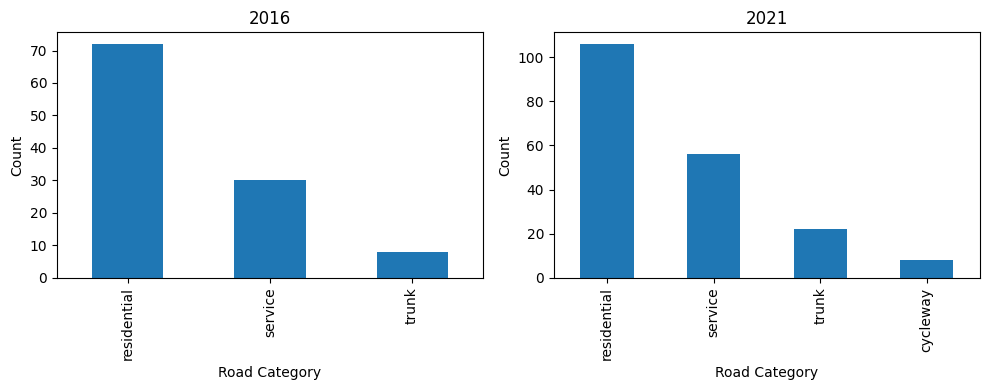

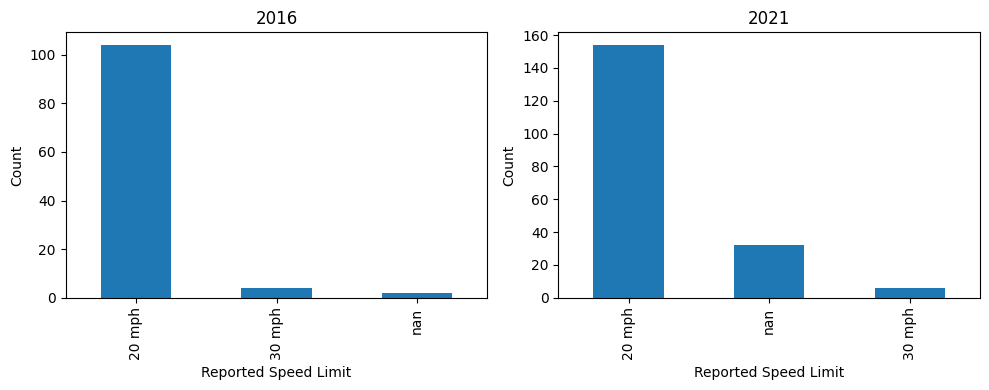

In [7]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['highway'].value_counts()
value_counts_2021 = edge_attributes_2021['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

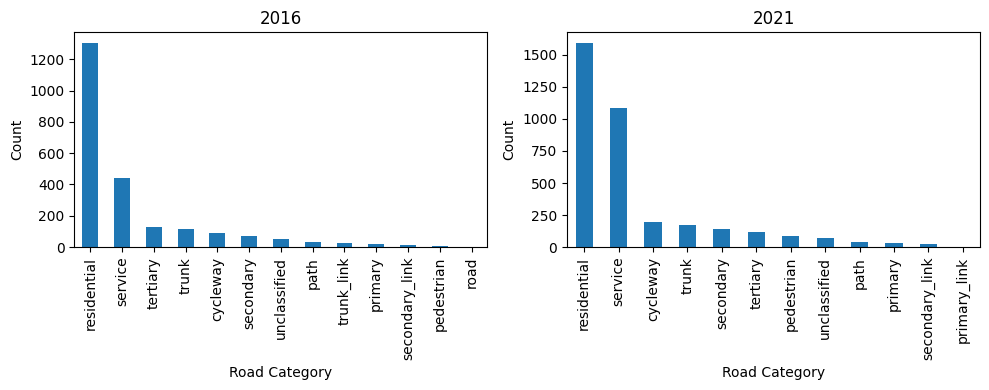

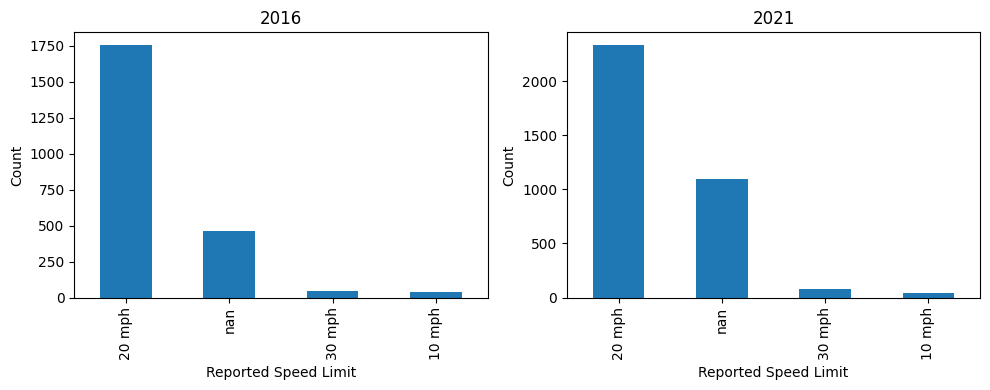

In [8]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['highway'].value_counts()
value_counts_2021 = edge_attributes_2021_exp_buffer['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021_exp_buffer['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

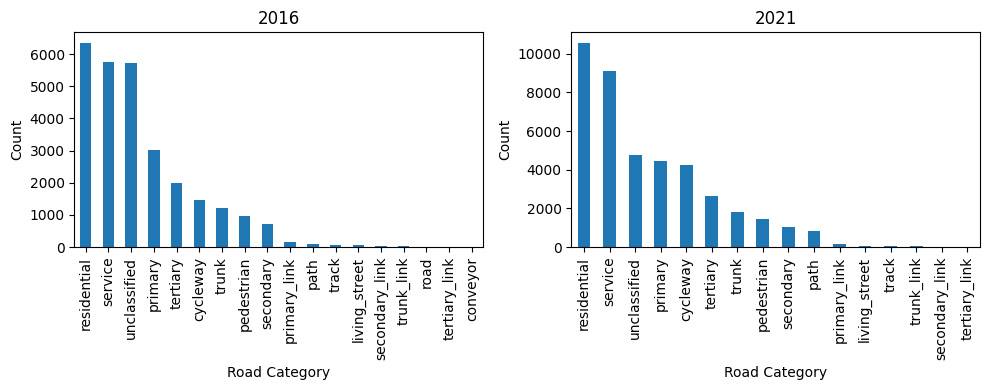

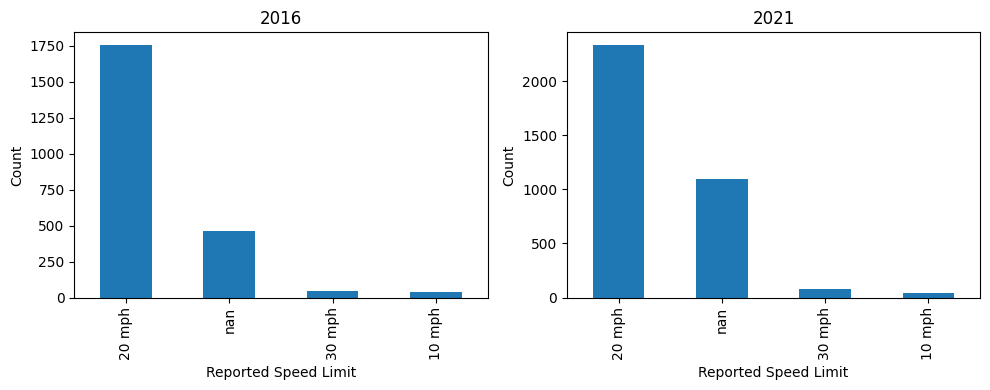

In [11]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_od_buffer['highway'].value_counts()
value_counts_2021 = edge_attributes_2021_od_buffer['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016_exp_buffer['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021_exp_buffer['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Part 2 - Efficiently measure LTS

In [12]:
import OSM2AT

#Cycle network
impute_method = 'mode-rule'
mlp_train_params = {
    'hidden_layer' : 100,
    'n_epochs' : 50,
    'batch_size' : 10
}
lts_method = 'ottawa'
self_learn_k = 5
pull_method = 'bb'
place = None

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:31: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True, useful_tags_way=utw)


### 2.1 LSOA networks

In [13]:
G_2016,edges_2016 = OSM2AT.measure_LTS_from_network(G_2016,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021,edges_2021 = OSM2AT.measure_LTS_from_network(G_2021,impute_method,mlp_train_params,lts_method,self_learn_k)

Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'geometry', 'cent_x', 'cent_y', 'edge_index', 'lanes'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method
Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'service', 'geometry', 'cent_x', 'cent_y', 'edge_index',
       'lanes'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = e

### 2.2 Expanded LSOA networks

In [14]:
#Expanded
G_2016_exp_buffer,edges_2016_exp_buffer = OSM2AT.measure_LTS_from_network(G_2016_exp_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021_exp_buffer,edges_2021_exp_buffer = OSM2AT.measure_LTS_from_network(G_2021_exp_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'service', 'lanes', 'bridge', 'est_width', 'access',
       'geometry', 'cent_x', 'cent_y', 'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed',
       'length', 'service', 'lanes', 'bridge', 'est_width', 'access', 'tunnel',
       'geometry', 'cent_x', 'cent_y', 'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


### 2.3 Expanded OD networks

In [15]:
#OD box
G_2016_od_buffer,edges_2016_od_buffer = OSM2AT.measure_LTS_from_network(G_2016_od_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)
G_2021_od_buffer,edges_2021_od_buffer = OSM2AT.measure_LTS_from_network(G_2021_od_buffer,impute_method,mlp_train_params,lts_method,self_learn_k)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'oneway',
       'reversed', 'length', 'bridge', 'access', 'tunnel', 'junction', 'width',
       'est_width', 'service', 'area', 'geometry', 'cent_x', 'cent_y',
       'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:232: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/OSM2AT/get_at_networks.py:233: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'oneway',
       'reversed', 'length', 'bridge', 'access', 'junction', 'tunnel', 'width',
       'service', 'est_width', 'area', 'geometry', 'cent_x', 'cent_y',
       'edge_index'],
      dtype='object')
Calculating LTS using Ottawa Advocacy Group method


### 2.4 View Distribution of LTS

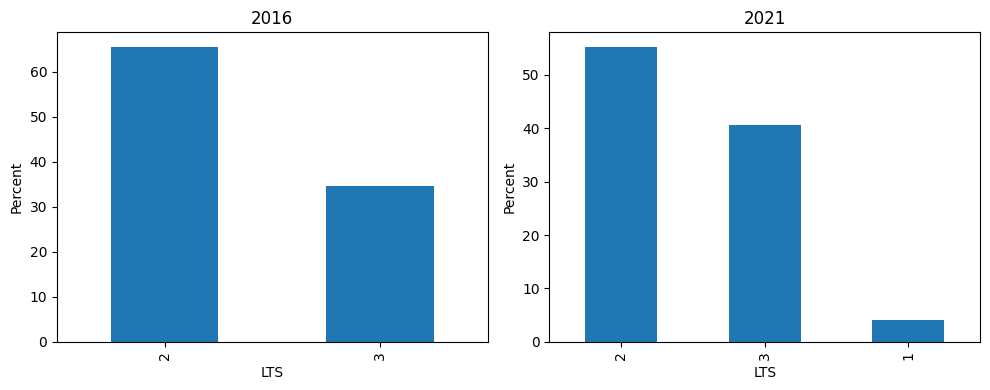

In [16]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016['LTS'].value_counts()
value_counts2 = edges_2021['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

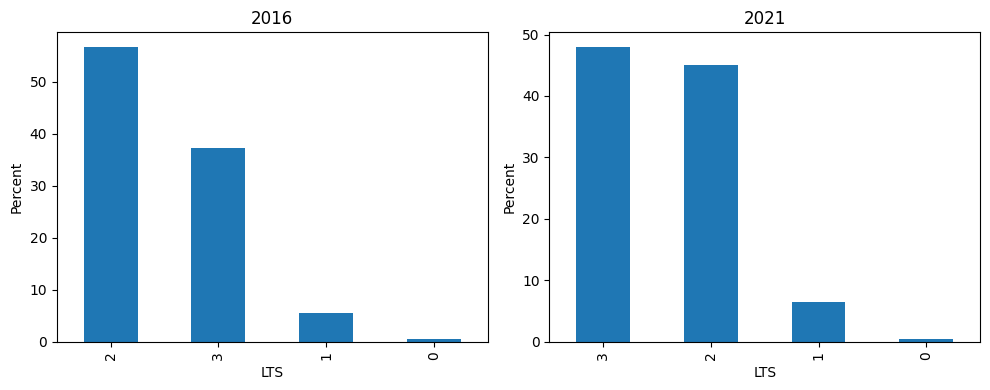

In [17]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016_exp_buffer['LTS'].value_counts()
value_counts2 = edges_2021_exp_buffer['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

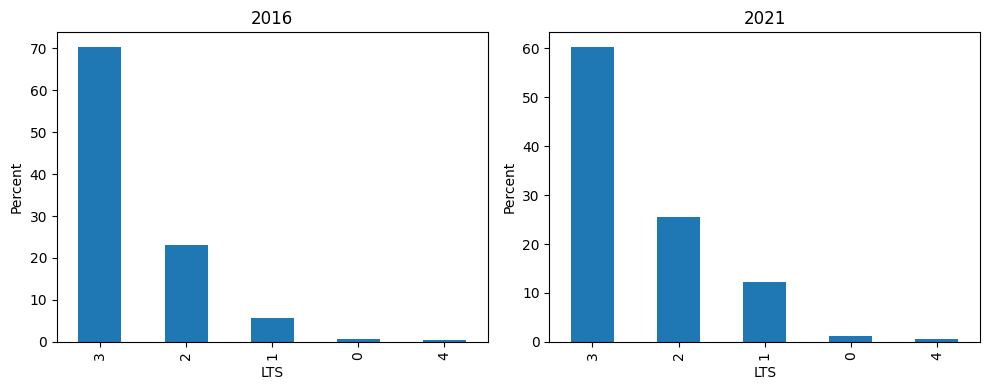

In [18]:
# Use value_counts to get counts of each category
value_counts1 = edges_2016_od_buffer['LTS'].value_counts()
value_counts2 = edges_2021_od_buffer['LTS'].value_counts()

# Calculate percentages
percentage1 = (value_counts1 / value_counts1.sum()) * 100
percentage2 = (value_counts2 / value_counts2.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage1.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage2.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

### 2.5 View Distribution of LTS Kilometres on Roads

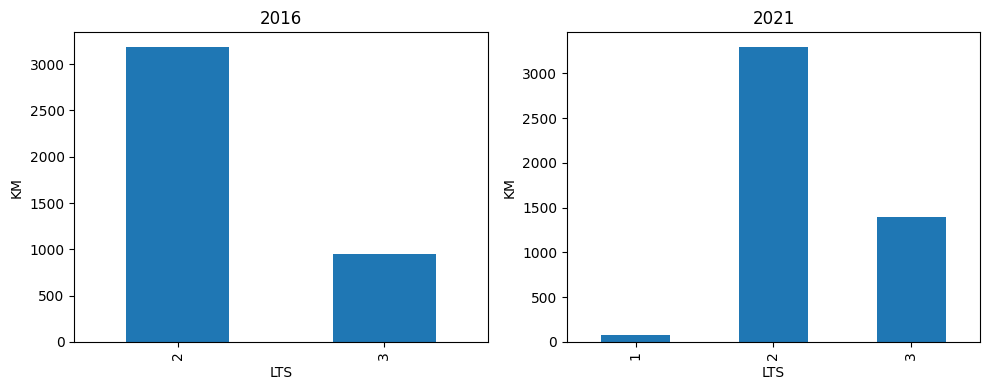

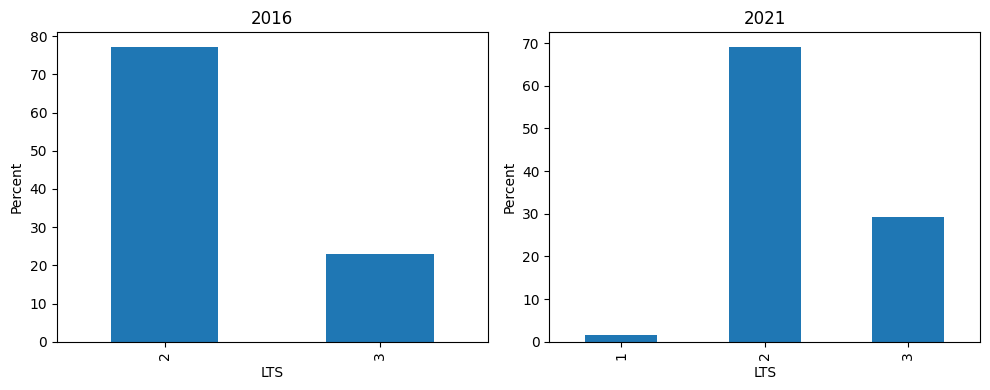

In [19]:
grouped_data_2016 = edges_2016.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

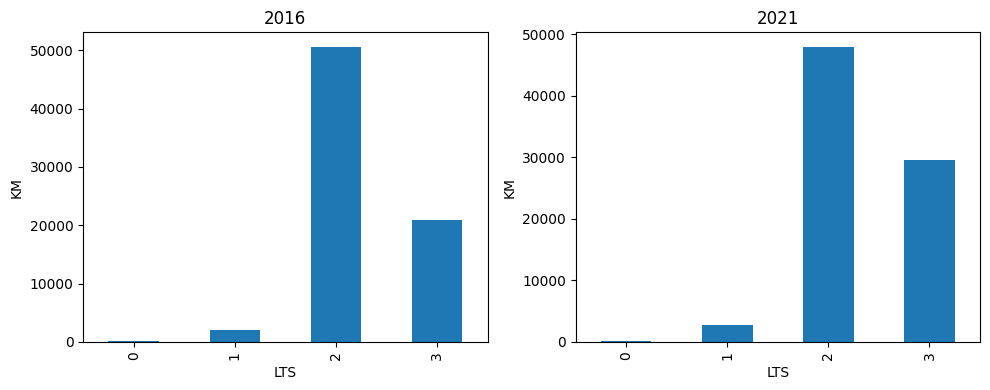

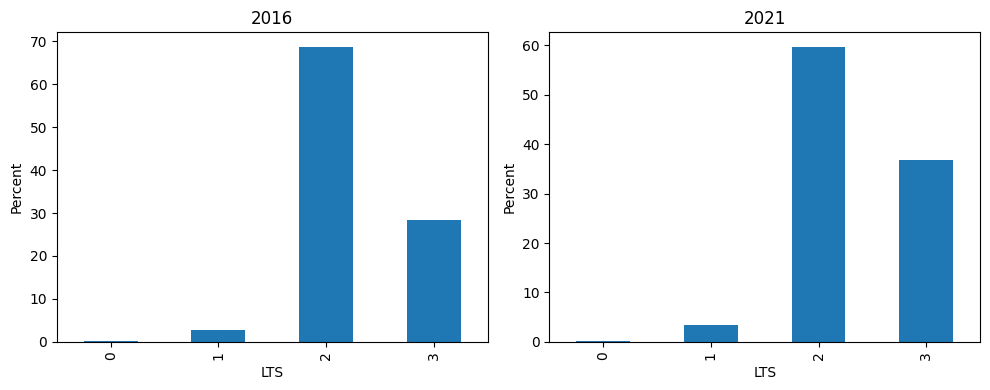

In [20]:
grouped_data_2016 = edges_2016_exp_buffer.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021_exp_buffer.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

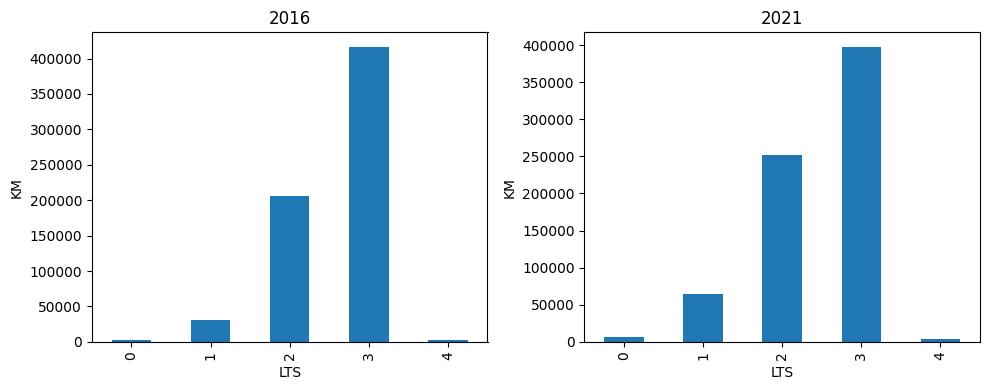

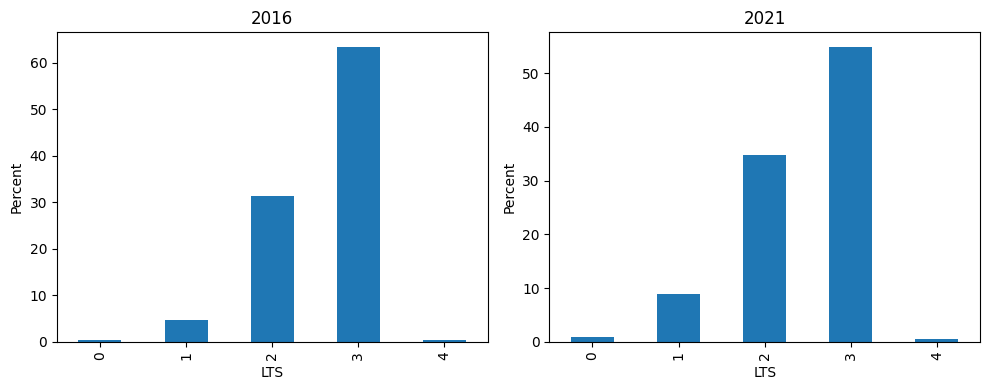

In [21]:
grouped_data_2016 = edges_2016_od_buffer.groupby('LTS')['length'].sum()
grouped_data_2021 = edges_2021_od_buffer.groupby('LTS')['length'].sum()

# Calculate percentages
percentage_2016 = (grouped_data_2016 / grouped_data_2016.sum()) * 100
percentage_2021 = (grouped_data_2021 / grouped_data_2021.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

grouped_data_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('KM')
axs[0].set_title('2016')

grouped_data_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('KM')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

percentage_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('LTS')
axs[0].set_ylabel('Percent')
axs[0].set_title('2016')

percentage_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('LTS')
axs[1].set_ylabel('Percent')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

# Part 3 - Routing Analysis

- Bring in buildings in LSOA
- Route to nearby POIs (e.g., shops, schools, train stations)
- Route to main desination point
    - Get top k routes
    - If time get pareto curve

In [22]:
# Get buildings 2016 - LSOA level
tags = {'building': True}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
buildings_lsoa = ox.features.features_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [38]:
latitudes = []
longitudes = []
for i,r in buildings_lsoa.iterrows():
    longitudes.append(r['geometry'].centroid.x)
    latitudes.append(r['geometry'].centroid.y)
buildings_lsoa['longitude']=longitudes
buildings_lsoa['latitude']=latitudes

In [23]:
# Get shops - expanded network
tags = {'railway': 'station'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
station_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [39]:
latitudes = []
longitudes = []
for i,r in station_exp_area.iterrows():
    longitudes.append(r['geometry'].centroid.x)
    latitudes.append(r['geometry'].centroid.y)
station_exp_area['longitude']=longitudes
station_exp_area['latitude']=latitudes

In [24]:
# Get train station - expanded network
tags = {'shop': 'supermarket'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
supermarkets_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [40]:
latitudes = []
longitudes = []
for i,r in supermarkets_exp_area.iterrows():
    longitudes.append(r['geometry'].centroid.x)
    latitudes.append(r['geometry'].centroid.y)
supermarkets_exp_area['longitude']=longitudes
supermarkets_exp_area['latitude']=latitudes

In [25]:
# Get schools - expanded network
tags = {'amenity': 'school'}
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
school_exp_area = ox.features.features_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0], tags)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.

In [41]:
latitudes = []
longitudes = []
for i,r in school_exp_area.iterrows():
    longitudes.append(r['geometry'].centroid.x)
    latitudes.append(r['geometry'].centroid.y)
school_exp_area['longitude']=longitudes
school_exp_area['latitude']=latitudes

In [ ]:
# Analysis 1 - Routing Profile
# Route from all houses (/centroid?) to all POI by type
# Get top k routes to each
# Analyse routes for LTS (e.g., km of each LTS)
# Observe change over time


In [69]:
school_exp_area

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


geometry  \
element_type osmid                                                           
node         4009990096                          POINT (-0.07315 51.46630)   
way          5548356     POLYGON ((-0.07216 51.47146, -0.07187 51.47149...   
             30240084    POLYGON ((-0.07314 51.47375, -0.07327 51.47357...   
             32134913    POLYGON ((-0.07062 51.46677, -0.07046 51.46648...   
             33324168    POLYGON ((-0.08285 51.46551, -0.08265 51.46561...   
             65382161    POLYGON ((-0.07402 51.47405, -0.07344 51.47389...   
             75059867    POLYGON ((-0.07795 51.46978, -0.07805 51.47005...   
             164080986   POLYGON ((-0.06493 51.47634, -0.06519 51.47632...   
             167571619   POLYGON ((-0.07825 51.47424, -0.07766 51.47434...   

                        amenity                                 name  \
element_type osmid                                                     
node         4009990096  school                Belham Primary School   
way          5548356     school                     Highshore School   
             30240084    school            Harris Academy at Peckham   
             32134913    school             Bellenden Primary School   
             33324168    school               Dog Kennel Hill School   
             65382161    school    St James the Great Primary School   
             75059867    school                            The Villa   
             164080986   school  Harris Primary Academy Peckham Park   
             167571619   school      Oliver Goldsmith Primary School   

                                                                     nodes  \
element_type osmid                                                           
node         4009990096                                                NaN   
way          5548356     [40891739, 870407748, 870407578, 870407918, 55...   
             30240084    [333129130, 333129131, 333129132, 870454672, 8...   
             32134913    [360736903, 360736906, 29622182, 21316634, 360...   
             33324168    [378996650, 931809882, 931810143, 2788709909, ...   
             65382161    [798638815, 798638904, 798638831, 798638781, 7...   
             75059867    [885984406, 885984422, 885984370, 885984318, 1...   
             164080986   [1757387427, 2916660675, 2916660674, 175738743...   
             167571619   [1789665983, 1789665994, 1789665992, 178966598...   

                                                            website  \
element_type osmid                                                    
node         4009990096                                         NaN   
way          5548356                                            NaN   
             30240084    http://www.peckhamacademy.southwark.sch.uk   
             32134913                                           NaN   
             33324168                        http://www.dkh.org.uk/   
             65382161                                           NaN   
             75059867                                           NaN   
             164080986                                          NaN   
             167571619                                          NaN   

                             addr:street addr:postcode addr:housenumber  \
element_type osmid                                                        
node         4009990096              NaN           NaN              NaN   
way          5548356                 NaN           NaN              NaN   
             30240084                NaN           NaN              NaN   
             32134913                NaN           NaN              NaN   
             33324168                NaN           NaN              NaN   
             65382161                NaN           NaN              NaN   
             75059867    Lyndhurst Grove      SE15 5AH               54   
             164080986               NaN           NaN              NaN   
             167571619 

In [44]:
# Get nearest node of houses and POIs

#Buildings
building_nodes_2016 = ox.nearest_nodes(G_2016_exp_buffer,list(buildings_lsoa['longitude']),list(buildings_lsoa['latitude']))
building_nodes_2021 = ox.nearest_nodes(G_2021_exp_buffer,list(buildings_lsoa['longitude']),list(buildings_lsoa['latitude']))

#Station
station_nodes_2016 = ox.nearest_nodes(G_2016_exp_buffer,list(station_exp_area['longitude']),list(station_exp_area['latitude']))
station_nodes_2021 = ox.nearest_nodes(G_2021_exp_buffer,list(station_exp_area['longitude']),list(station_exp_area['latitude']))

#Shop
shop_nodes_2016 = ox.nearest_nodes(G_2016_exp_buffer,list(supermarkets_exp_area['longitude']),list(supermarkets_exp_area['latitude']))
shop_nodes_2021 = ox.nearest_nodes(G_2021_exp_buffer,list(supermarkets_exp_area['longitude']),list(supermarkets_exp_area['latitude']))

#School
school_nodes_2016 = ox.nearest_nodes(G_2016_exp_buffer,list(school_exp_area['longitude']),list(school_exp_area['latitude']))
school_nodes_2021 = ox.nearest_nodes(G_2021_exp_buffer,list(school_exp_area['longitude']),list(school_exp_area['latitude']))

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/e

In [45]:
o = building_nodes_2016[0]
d = station_nodes_2016[0]

In [47]:
# Get top k routes (use length)
k = 5
best_paths = ox.routing.k_shortest_paths(G_2016_exp_buffer, o, d, k, weight='length')

In [ ]:
year, poi type, 

In [66]:
for p in best_paths:
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        lts = edges_2016_exp_buffer.loc[u,v,0]['LTS']
        length = edges_2016_exp_buffer.loc[u,v,0]['length']
        
        if lts == 0:
            lts0 += length
        if lts == 1:
            lts1 += length
        if lts == 2:
            lts2 += length
        if lts == 3:
            lts3 += length
        if lts == 4:
            lts4 += length
        u = v

In [50]:
lts0 = 0
lts1 = 0
lts2 = 0
lts3 = 0
lts4 = 0

0
28.356
889.5840000000001
179.15300000000002
0


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


In [54]:
G_2016_exp_buffer[u][v][0]

{'osmid': 73424641,
 'highway': 'service',
 'oneway': False,
 'reversed': True,
 'length': 28.678}

In [ ]:
# Analysis 2 - LTS routing potential
# Remove LTS 4 from network now route - how does it impact on times
# Remove LTS 3 from network - how does it impact?

In [ ]:
# Analysis 3 - similar to above but now route from origin centroid to destination centroid

In [ ]:


    reachable_123 = 0
    reachable_12 = 0
    num_building = 0
    building_points_x = []
    building_points_y = []
    for i in list(buildings['geometry']):
        nearest_point_on_line, _ = nearest_points(i, sensor_point)
        building_points_x.append(nearest_point_on_line.x)
        building_points_y.append(nearest_point_on_line.y)
        
    building_nodes = ox.distance.nearest_nodes(G, building_points_x, building_points_y, return_dist=False)

    reachable_123 = 0
    reachable_12 = 0
    num_building = 0
    for i in building_nodes:
        if i in nodes_reached_lts_123:
            reachable_123 += 1
        if i in nodes_reached_lts_12:
            reachable_12 += 1
            
        num_building += 1

    percent_reachable_lts_123 = (reachable_123 / len(buildings)) * 100
    percent_reachable_lts_12 = (reachable_12 / len(buildings)) * 100

In [ ]:
origin_geom = lsoa['geometry'].values[0]
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']

In [86]:
# Get LSOA centroid
o_lon = origin_geom.centroid.x
o_lat = origin_geom.centroid.y

# Get destination lsoa centroid
d_lon = destination_geom.centroid.x
d_lat = destination_geom.centroid.y

In [121]:
# Get top k routes (use length)
k = 5
best_paths_2016 = ox.routing.k_shortest_paths(G_2016_od_buffer, ox.nearest_nodes(G_2016_od_buffer,o_lon,o_lat), ox.nearest_nodes(G_2016_od_buffer,d_lon,d_lat), k, weight='length')
best_paths_2021 = ox.routing.k_shortest_paths(G_2021_od_buffer, ox.nearest_nodes(G_2021_od_buffer,o_lon,o_lat), ox.nearest_nodes(G_2021_od_buffer,d_lon,d_lat), k, weight='length')

# Get KM by LTS

path_results_list = []

path_num = 1

for p in best_paths_2016:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2016_od_buffer.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2016'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1
    
path_num = 1
for p in best_paths_2021:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2021_od_buffer.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2021'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1

path_results = pd.DataFrame(path_results_list)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

In [145]:
# Take out LTS 4 then re-route

G_2016_od_buffer_no_lts4 = G_2016_od_buffer.copy()
edges_2016_od_buffer_no_lts4 = edges_2016_od_buffer.copy()
for i,r in edges_2016_od_buffer[edges_2016_od_buffer['LTS'] == 4].iterrows():
    G_2016_od_buffer_no_lts4.remove_edge(i[0],i[1],0)
    edges_2016_od_buffer_no_lts4 = edges_2016_od_buffer_no_lts4.drop(i)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [144]:
G_2021_od_buffer_no_lts4 = G_2021_od_buffer.copy()
edges_2021_od_buffer_no_lts4 = edges_2021_od_buffer.copy()
for i,r in edges_2021_od_buffer[edges_2021_od_buffer['LTS'] == 4].iterrows():
    G_2021_od_buffer_no_lts4.remove_edge(i[0],i[1],0)
    edges_2021_od_buffer_no_lts4 = edges_2021_od_buffer_no_lts4.drop(i)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [147]:
# Get top k routes (use length)
k = 5
best_paths_n0lts4_2016 = ox.routing.k_shortest_paths(G_2016_od_buffer_no_lts4, ox.nearest_nodes(G_2016_od_buffer_no_lts4,o_lon,o_lat), ox.nearest_nodes(G_2016_od_buffer_no_lts4,d_lon,d_lat), k, weight='length')
best_paths_n0lts4_2021 = ox.routing.k_shortest_paths(G_2021_od_buffer_no_lts4, ox.nearest_nodes(G_2021_od_buffer_no_lts4,o_lon,o_lat), ox.nearest_nodes(G_2021_od_buffer_no_lts4,d_lon,d_lat), k, weight='length')

# Get KM by LTS

path_results_list = []

path_num = 1

for p in best_paths_n0lts4_2016:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2016_od_buffer_no_lts4.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2016'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1
    
path_num = 1
for p in best_paths_n0lts4_2021:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2021_od_buffer_no_lts4.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2021'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1

path_results_no_lts4 = pd.DataFrame(path_results_list)

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

In [155]:
path_results_no_lts4.iloc[5][['lts0','lts1','lts2','lts3','lts4']].sum()
path_results.iloc[5][['lts0','lts1','lts2','lts3','lts4']].sum()

5701.611000000003

In [173]:
# Make LTS 3 more expensive

G_2016_od_buffer_lts3_more = G_2016_od_buffer_no_lts4.copy()
edges_2016_od_buffer_lts3_more = edges_2016_od_buffer_no_lts4.copy()
for i,r in edges_2016_od_buffer_no_lts4[edges_2016_od_buffer_no_lts4['LTS'] == 3].iterrows():
    new_edge_length = (G_2016_od_buffer_lts3_more[i[0]][i[1]][0]['length'] * 1.5)
    G_2016_od_buffer_lts3_more[i[0]][i[1]][0]['length'] = new_edge_length
    edges_2016_od_buffer_lts3_more.at[i,'length'] = new_edge_length
    
G_2021_od_buffer_lts3_more = G_2021_od_buffer_no_lts4.copy()
edges_2021_od_buffer_lts3_more = edges_2021_od_buffer_no_lts4.copy()
for i,r in edges_2021_od_buffer_no_lts4[edges_2021_od_buffer_no_lts4['LTS'] == 3].iterrows():
    new_edge_length = (G_2021_od_buffer_lts3_more[i[0]][i[1]][0]['length'] * 1.5)
    G_2021_od_buffer_lts3_more[i[0]][i[1]][0]['length'] = new_edge_length
    edges_2021_od_buffer_lts3_more.at[i,'length'] = new_edge_length

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [175]:
# Get top k routes (use length)
k = 5
best_paths_lts3_more_2016 = ox.routing.k_shortest_paths(G_2016_od_buffer_lts3_more, ox.nearest_nodes(G_2016_od_buffer_lts3_more,o_lon,o_lat), ox.nearest_nodes(G_2016_od_buffer_lts3_more,d_lon,d_lat), k, weight='length')
best_paths_lts3_more_2021 = ox.routing.k_shortest_paths(G_2021_od_buffer_lts3_more, ox.nearest_nodes(G_2021_od_buffer_lts3_more,o_lon,o_lat), ox.nearest_nodes(G_2021_od_buffer_lts3_more,d_lon,d_lat), k, weight='length')

# Get KM by LTS

path_results_list = []

path_num = 1

for p in best_paths_lts3_more_2016:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2016_od_buffer_lts3_more.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2016'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1
    
path_num = 1
for p in best_paths_lts3_more_2021:
    print('next path')
    lts0 = 0
    lts1 = 0
    lts2 = 0
    lts3 = 0
    lts4 = 0

    u = p[0]
    for v in p[1:]:
        edge = edges_2021_od_buffer_lts3_more.loc[u,v,0][['LTS','length']]
        if edge['LTS'] == 0:
            lts0 += edge['length']
        if edge['LTS'] == 1:
            lts1 += edge['length']
        if edge['LTS'] == 2:
            lts2 += edge['length']
        if edge['LTS'] == 3:
            lts3 += edge['length']
        if edge['LTS'] == 4:
            lts4 += edge['length']
        u = v
    path_result_append = {}
    path_result_append['year'] = '2021'
    path_result_append['path'] = path_num
    path_result_append['lts0'] = lts0
    path_result_append['lts1'] = lts1
    path_result_append['lts2'] = lts2
    path_result_append['lts3'] = lts3
    path_result_append['lts4'] = lts4
    path_results_list.append(path_result_append)
    path_num += 1

path_results_lts3_more = pd.DataFrame(path_results_list)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

next path


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public A

In [177]:
print(path_results_lts3_more.iloc[0][['lts0','lts1','lts2','lts3','lts4']].sum())
print(path_results_no_lts4.iloc[0][['lts0','lts1','lts2','lts3','lts4']].sum())
print(path_results.iloc[0][['lts0','lts1','lts2','lts3','lts4']].sum())

7692.811499999998
5879.1579999999985
5858.351999999999


In [178]:
print(path_results_lts3_more.iloc[5][['lts0','lts1','lts2','lts3','lts4']].sum())
print(path_results_no_lts4.iloc[5][['lts0','lts1','lts2','lts3','lts4']].sum())
print(path_results.iloc[5][['lts0','lts1','lts2','lts3','lts4']].sum())

6942.157500000001
5701.611000000003
5677.635000000002


# Part 4 - Centrlity Analysis

- Simple centrality measure
- LTS weighted centrality

In [180]:
import networkx as nx

In [183]:
# Compute edge betweenness centrality
edge_betweenness_centrality_2016 = nx.edge_betweenness_centrality(G_2016)
edge_betweenness_centrality_2021 = nx.edge_betweenness_centrality(G_2021)

In [ ]:
# Weighted centrality